In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf

from keras.applications import ResNet50
from keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/face_emotions/train/',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

In [ ]:
test_dataset = test_datagen.flow_from_directory(directory ='/content/drive/MyDrive/face_emotions/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator, load_img

from keras_preprocessing import image
img = image.load_img("/content/drive/MyDrive/face_emotions/test/angry/PrivateTest_10131363.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [ ]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")
base_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                          

In [ ]:
# Freezing Layers
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [ ]:
# Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_5 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_6 (Batc  (None, 32)               128       
 hNormalization)                                      

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
Model_fit = model.fit(train_dataset,validation_data=test_dataset,epochs = 30,callbacks=[lrd,es])

Epoch 1/30
359/359 [==============================] - 5310s 15s/step - loss: 1.9127 - accuracy: 0.8548 - val_loss: 1.8212 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 2/30
359/359 [==============================] - 64s 178ms/step - loss: 1.8365 - accuracy: 0.8570 - val_loss: 1.8299 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 3/30
359/359 [==============================] - 64s 179ms/step - loss: 1.8231 - accuracy: 0.8571 - val_loss: 1.8036 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/30
359/359 [==============================] - 63s 175ms/step - loss: 1.8181 - accuracy: 0.8571 - val_loss: 1.8056 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 5/30
359/359 [==============================] - 64s 177ms/step - loss: 1.8127 - accuracy: 0.8571 - val_loss: 1.7991 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 6/30
359/359 [==============================] - 63s 176ms/step - loss: 1.8116 - accuracy: 0.8571 - val_loss: 1.7963 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 7/30
359/359 [==============================] 

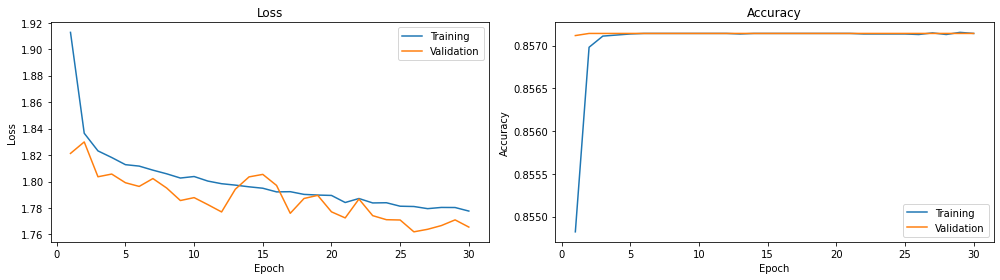

In [ ]:
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

113/113 [==============================] - 1322s 12s/step - loss: 2.8503 - accuracy: 0.8464


In [ ]:
model_json = model.to_json()
with open("Model_ResNet50.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("Model_ResNet50.h5")
print("Saved model to disk")

Saved model to disk
